In [5]:
# ============================================================================
# BREAKOUT STRATEGY BACKTEST - NSE MONTHLY CHARTS
# ============================================================================
# Strategy: Breakout above All-Time High (ATH) with Volume + EMA Confirmation
# Entry: Close > ATH (prior month) AND Volume > 6-month avg AND Close > 12-month EMA
# Exit: Trailing stop loss (20%) OR max hold 12 months OR end of data
# ============================================================================

import sys
import subprocess
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import datetime

# Install/upgrade packages if needed
packages = ['yfinance', 'pandas', 'numpy', 'matplotlib', 'tqdm']
try:
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', '--upgrade', '-q'] + packages)
except:
    pass

print('Environment ready.')

Environment ready.



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: /opt/homebrew/Cellar/jupyterlab/4.3.5/libexec/bin/python -m pip install --upgrade pip


In [6]:
# ============================================================================
# STEP 1: STRATEGY PARAMETERS
# ============================================================================

# Data period
START_DATE = '2010-01-01'                # backtest start date
END_DATE = '2025-10-15'                  # backtest end date (today approx)

# Strategy parameters
VOL_LOOKBACK = 6                         # months of history for avg volume
EMA_PERIOD = 12                          # 12-month EMA for trend
TRAIL_STOP_PCT = 0.20                    # 20% trailing stop loss

# Costs and slippage
TXN_COST = 0.0005                        # 0.05% per transaction (0.1% round trip)
SLIPPAGE = 0.001                         # 0.1% slippage on fills

# Data requirements
MIN_MONTHS_HISTORY = 36                  # minimum 3 years of monthly data required

# ATR-based stops (optional, currently disabled)
USE_ATR = False                          # set True to use ATR-based stops
ATR_MULTIPLIER = 3.0                     # ATR multiple for stop distance

print('Strategy Parameters:')
print(f'  Period: {START_DATE} to {END_DATE}')
print(f'  Entry: Breakout above ATH + High Volume + Above 12-month EMA')
print(f'  Exit: {TRAIL_STOP_PCT*100:.0f}% trailing stop (held until stopped out or end of data)')
print(f'  Costs: {TXN_COST*100:.02f}% per txn + {SLIPPAGE*100:.01f}% slippage')

Strategy Parameters:
  Period: 2010-01-01 to 2025-10-15
  Entry: Breakout above ATH + High Volume + Above 12-month EMA
  Exit: 20% trailing stop (held until stopped out or end of data)
  Costs: 0.05% per txn + 0.1% slippage


In [7]:
# ============================================================================
# STEP 2: NSE TICKERS
# ============================================================================

# Sample of 10 NSE tickers (replace with full NSE-500 list for production)
tickers = [
    'RELIANCE', 'TCS', 'INFY', 'HDFCBANK', 'ICICIBANK',
    'LT', 'SBIN', 'BHARTIARTL', 'ASIANPAINT', 'BAJFINANCE'
]

print(f'\nTickers to backtest: {len(tickers)}')
print('  ' + ', '.join(tickers))
print('\nNote: To test full NSE-500, replace tickers list with complete NSE-500 symbols.')


Tickers to backtest: 10
  RELIANCE, TCS, INFY, HDFCBANK, ICICIBANK, LT, SBIN, BHARTIARTL, ASIANPAINT, BAJFINANCE

Note: To test full NSE-500, replace tickers list with complete NSE-500 symbols.


In [8]:
# ============================================================================
# STEP 3: HELPER FUNCTIONS
# ============================================================================

def download_monthly_data(ticker):
    """
    Download daily OHLCV data from Yahoo Finance and resample to monthly bars.
    Add technical indicators: 12-month EMA and ATR.
    """
    try:
        # Download daily data
        df = yf.download(f'{ticker}.NS', start=START_DATE, end=END_DATE, progress=False)
        if df is None or df.empty:
            return None
        
        df.index = pd.to_datetime(df.index)
        
        # Flatten MultiIndex or tuple columns if present
        if isinstance(df.columns, pd.MultiIndex):
            df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]
        else:
            df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]
        
        # Get column names as strings for easier matching
        col_names = [str(c) for c in df.columns]
        col_map = {name.lower(): name for name in col_names}
        
        # Find required OHLCV columns (case-insensitive)
        open_col = None
        high_col = None
        low_col = None
        close_col = None
        volume_col = None
        
        for key in col_map:
            if 'open' in key:
                open_col = col_map[key]
            elif 'high' in key:
                high_col = col_map[key]
            elif 'low' in key and 'close' not in key:
                low_col = col_map[key]
            elif 'close' in key or 'adj' in key:
                close_col = col_map[key]
            elif 'volume' in key:
                volume_col = col_map[key]
        
        if not all([open_col, high_col, low_col, close_col, volume_col]):
            return None
        
        # Select and rename columns
        df_clean = df[[open_col, high_col, low_col, close_col, volume_col]].copy()
        df_clean.columns = ['open', 'high', 'low', 'close', 'volume']
        
        # Resample daily to monthly OHLCV
        m = df_clean.resample('M').agg({
            'open': 'first',
            'high': 'max',
            'low': 'min',
            'close': 'last',
            'volume': 'sum'
        })
        m = m.dropna()
        
        # Check minimum history requirement
        if m.empty or len(m) < MIN_MONTHS_HISTORY:
            return None
        
        # Calculate indicators
        m['ema12'] = m['close'].ewm(span=EMA_PERIOD, adjust=False).mean()
        
        # ATR calculation: True Range over last 12 months
        tr = pd.concat([
            m['high'] - m['low'],
            (m['high'] - m['close'].shift(1)).abs(),
            (m['low'] - m['close'].shift(1)).abs()
        ], axis=1).max(axis=1)
        m['atr'] = tr.rolling(EMA_PERIOD).mean()
        
        return m
    except Exception as e:
        print(f'Error {ticker}: {e}')
        return None


def backtest_ticker(monthly, ticker):
    """
    Backtest breakout strategy on monthly bars.
    Entry: breakout above ATH + high volume + above EMA.
    Exit: trailing stop loss or end of data.
    """
    trades = []
    m = monthly.copy()
    
    # Calculate signals
    m['prior_ath'] = m['close'].expanding().max().shift(1)     # ATH from prior months
    m['vol_avg'] = m['volume'].rolling(VOL_LOOKBACK).mean().shift(1)  # avg volume from prior months
    
    for i in range(len(m)):
        r = m.iloc[i]
        
        # Skip if not enough prior data for indicators
        if pd.isna(r.get('prior_ath')) or pd.isna(r.get('vol_avg')) or pd.isna(r.get('ema12')):
            continue
        
        # ENTRY CONDITION: Breakout above ATH + High Volume + Above EMA
        if (r['close'] > r['prior_ath']) and (r['volume'] > r['vol_avg']) and (r['close'] > r['ema12']):
            entry_price = r['close'] * (1 + SLIPPAGE)  # apply entry slippage
            entry_date = m.index[i]
            
            # Initialize trailing stop
            highest = max(r['high'] if not pd.isna(r.get('high')) else r['close'], entry_price)
            stop = highest * (1 - TRAIL_STOP_PCT)
            reason = None
            exit_price = None
            exit_date = None
            
            # HOLD LOOP: track position until exit
            for j in range(i+1, len(m)):
                rr = m.iloc[j]
                
                # Update trailing highest
                if not pd.isna(rr.get('high')) and rr['high'] > highest:
                    highest = rr['high']
                
                # Update trailing stop
                if USE_ATR and not pd.isna(rr.get('atr')):
                    stop = highest - (ATR_MULTIPLIER * rr['atr'])
                else:
                    stop = highest * (1 - TRAIL_STOP_PCT)
                
                if pd.isna(stop):
                    continue
                
                # EXIT CONDITION 1: Stop loss hit
                if (not pd.isna(rr.get('low'))) and (rr['low'] <= stop):
                    exit_price = stop * (1 - SLIPPAGE)
                    exit_date = m.index[j]
                    reason = 'stop_loss'
                    break
            else:
                # EXIT CONDITION 2: End of data reached
                exit_price = m['close'].iloc[-1] * (1 - SLIPPAGE)
                exit_date = m.index[-1]
                reason = 'end_data'
            
            # Calculate returns
            if exit_price is not None and exit_date is not None:
                gross_ret = (exit_price - entry_price) / entry_price
                net_ret = gross_ret - 2 * TXN_COST  # subtract round-trip costs
                
                trades.append({
                    'ticker': ticker,
                    'entry_date': entry_date,
                    'exit_date': exit_date,
                    'entry_price': entry_price,
                    'exit_price': exit_price,
                    'months_held': j - i,
                    'gross_return': gross_ret,
                    'net_return': net_ret,
                    'exit_reason': reason
                })
    
    return trades

print('Helper functions defined.')

Helper functions defined.


In [9]:
# ============================================================================
# STEP 4: RUN BACKTEST
# ============================================================================

print(f'\nRunning backtest on {len(tickers)} tickers...')
print('='*70)

all_trades = []
successful_tickers = 0
failed_tickers = 0

for t in tqdm(tickers, desc='Downloading & Processing Tickers'):
    data = download_monthly_data(t)
    if data is None:
        failed_tickers += 1
        continue
    
    successful_tickers += 1
    trades = backtest_ticker(data, t)
    all_trades.extend(trades)

print(f'\nTickers with data: {successful_tickers}/{len(tickers)}')
print(f'Tickers skipped (insufficient history): {failed_tickers}/{len(tickers)}')

# Create results DataFrame
results = pd.DataFrame(all_trades)
print(f'\nTotal trades generated: {len(results)}')

if not results.empty:
    print(f'Date range of trades: {results["entry_date"].min().date()} to {results["exit_date"].max().date()}')


Running backtest on 10 tickers...


  df = yf.download(f'{ticker}.NS', start=START_DATE, end=END_DATE, progress=False)
/var/folders/pp/_wqh4hx94h37q97ctrt4rqf00000gn/T/ipykernel_31971/3804576459.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(f'{ticker}.NS', start=START_DATE, end=END_DATE, progress=False)
/var/folders/pp/_wqh4hx94h37q97ctrt4rqf00000gn/T/ipykernel_31971/3804576459.py:55: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  m = df_clean.resample('M').agg({
  m = df_clean.resample('M').agg({
  df = yf.download(f'{ticker}.NS', start=START_DATE, end=END_DATE, progress=False)
/var/folders/pp/_wqh4hx94h37q97ctrt4rqf00000gn/T/ipykernel_31971/3804576459.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(f'{ticker}.NS', start=START_DATE, end=END_DATE, progress=False)
/var/folders/pp/_wqh4hx94h37q97ctrt4rqf00000gn/T/ipykernel_31971/3804576459.py:55: FutureWarni


Tickers with data: 10/10
Tickers skipped (insufficient history): 0/10

Total trades generated: 195
Date range of trades: 2010-07-31 to 2025-10-31


In [10]:
# ============================================================================
# STEP 5: PERFORMANCE ANALYSIS
# ============================================================================

print('\n' + '='*70)
print('BREAKOUT STRATEGY - MONTHLY CHARTS PERFORMANCE REPORT')
print('='*70)

if not results.empty:
    # Trade statistics
    winners = results[results['net_return'] > 0]
    losers = results[results['net_return'] <= 0]
    total_trades = len(results)
    win_count = len(winners)
    loss_count = len(losers)
    win_rate = (win_count / total_trades * 100) if total_trades > 0 else 0
    
    # Returns
    avg_win = winners['net_return'].mean() * 100 if not winners.empty else 0
    avg_loss = losers['net_return'].mean() * 100 if not losers.empty else 0
    max_win = results['net_return'].max() * 100
    max_loss = results['net_return'].min() * 100
    total_return = results['net_return'].sum() * 100
    avg_return_per_trade = results['net_return'].mean() * 100
    
    # Profit factor
    gross_wins = winners['net_return'].sum() if not winners.empty else 0
    gross_losses = abs(losers['net_return'].sum()) if not losers.empty else 0
    profit_factor = (gross_wins / gross_losses) if gross_losses > 0 else (np.inf if gross_wins > 0 else 0)
    
    # Hold time
    avg_hold = results['months_held'].mean()
    median_hold = results['months_held'].median()
    
    # Print summary
    print(f'\n📊 TRADE SUMMARY')
    print(f'  Total Trades: {total_trades}')
    print(f'  Winning Trades: {win_count} ({win_rate:.1f}%)')
    print(f'  Losing Trades: {loss_count} ({100-win_rate:.1f}%)')
    
    print(f'\n💰 RETURNS')
    print(f'  Total Return: {total_return:.2f}%')
    print(f'  Avg Return/Trade: {avg_return_per_trade:.2f}%')
    print(f'  Avg Winner: {avg_win:.2f}%')
    print(f'  Avg Loser: {avg_loss:.2f}%')
    print(f'  Best Trade: {max_win:.2f}%')
    print(f'  Worst Trade: {max_loss:.2f}%')
    print(f'  Profit Factor: {profit_factor:.2f}' if profit_factor != np.inf else f'  Profit Factor: ∞ (only winners)')
    
    print(f'\n⏱️  HOLDING PERIOD')
    print(f'  Avg Hold: {avg_hold:.1f} months')
    print(f'  Median Hold: {median_hold:.0f} months')
    
    print(f'\n🔄 EXIT REASONS')
    exit_counts = results['exit_reason'].value_counts()
    for reason, count in exit_counts.items():
        pct = (count / total_trades) * 100
        print(f'  {reason}: {count} ({pct:.1f}%)')
    
    print(f'\n📈 PER-TICKER PERFORMANCE')
    ticker_stats = results.groupby('ticker').agg({
        'net_return': ['count', 'mean', 'sum'],
        'months_held': 'mean'
    }).round(4)
    ticker_stats.columns = ['trades', 'avg_return', 'total_return', 'avg_hold']
    ticker_stats = ticker_stats.sort_values('trades', ascending=False)
    
    for ticker_name, row in ticker_stats.iterrows():
        trades_cnt = int(row['trades'])
        avg_ret = row['avg_return'] * 100
        total_ret = row['total_return'] * 100
        avg_h = row['avg_hold']
        ticker_wr = (results[(results['ticker'] == ticker_name) & (results['net_return'] > 0)].shape[0] / trades_cnt * 100) if trades_cnt > 0 else 0
        print(f'  {ticker_name}: {trades_cnt} trades, {ticker_wr:.0f}% WR, {avg_ret:.2f}% avg, {total_ret:.2f}% total, {avg_h:.1f}mo')
    
    print('\n' + '='*70)
else:
    print('\n⚠️  NO TRADES FOUND')
    print('The strategy did not generate any trades with the current parameters.')
    print('Try:')
    print('  - Relaxing entry filters (e.g., reduce EMA_PERIOD, VOL_LOOKBACK)')
    print('  - Lowering TRAIL_STOP_PCT')
    print('  - Adding more tickers with longer history')


BREAKOUT STRATEGY - MONTHLY CHARTS PERFORMANCE REPORT

📊 TRADE SUMMARY
  Total Trades: 195
  Winning Trades: 90 (46.2%)
  Losing Trades: 105 (53.8%)

💰 RETURNS
  Total Return: 1526.80%
  Avg Return/Trade: 7.83%
  Avg Winner: 30.24%
  Avg Loser: -11.38%
  Best Trade: 175.10%
  Worst Trade: -19.78%
  Profit Factor: 2.28

⏱️  HOLDING PERIOD
  Avg Hold: 10.7 months
  Median Hold: 7 months

🔄 EXIT REASONS
  stop_loss: 181 (92.8%)
  end_data: 14 (7.2%)

📈 PER-TICKER PERFORMANCE
  BAJFINANCE: 29 trades, 59% WR, 16.79% avg, 486.80% total, 5.9mo
  ASIANPAINT: 25 trades, 36% WR, -1.02% avg, -25.61% total, 7.2mo
  TCS: 25 trades, 44% WR, 1.52% avg, 38.06% total, 11.6mo
  BHARTIARTL: 20 trades, 50% WR, 13.03% avg, 260.58% total, 9.1mo
  HDFCBANK: 19 trades, 47% WR, 18.05% avg, 342.97% total, 22.8mo
  ICICIBANK: 18 trades, 67% WR, 12.07% avg, 217.21% total, 12.3mo
  RELIANCE: 16 trades, 44% WR, 12.44% avg, 199.10% total, 9.3mo
  INFY: 15 trades, 33% WR, 1.00% avg, 14.94% total, 10.2mo
  LT: 14 tra

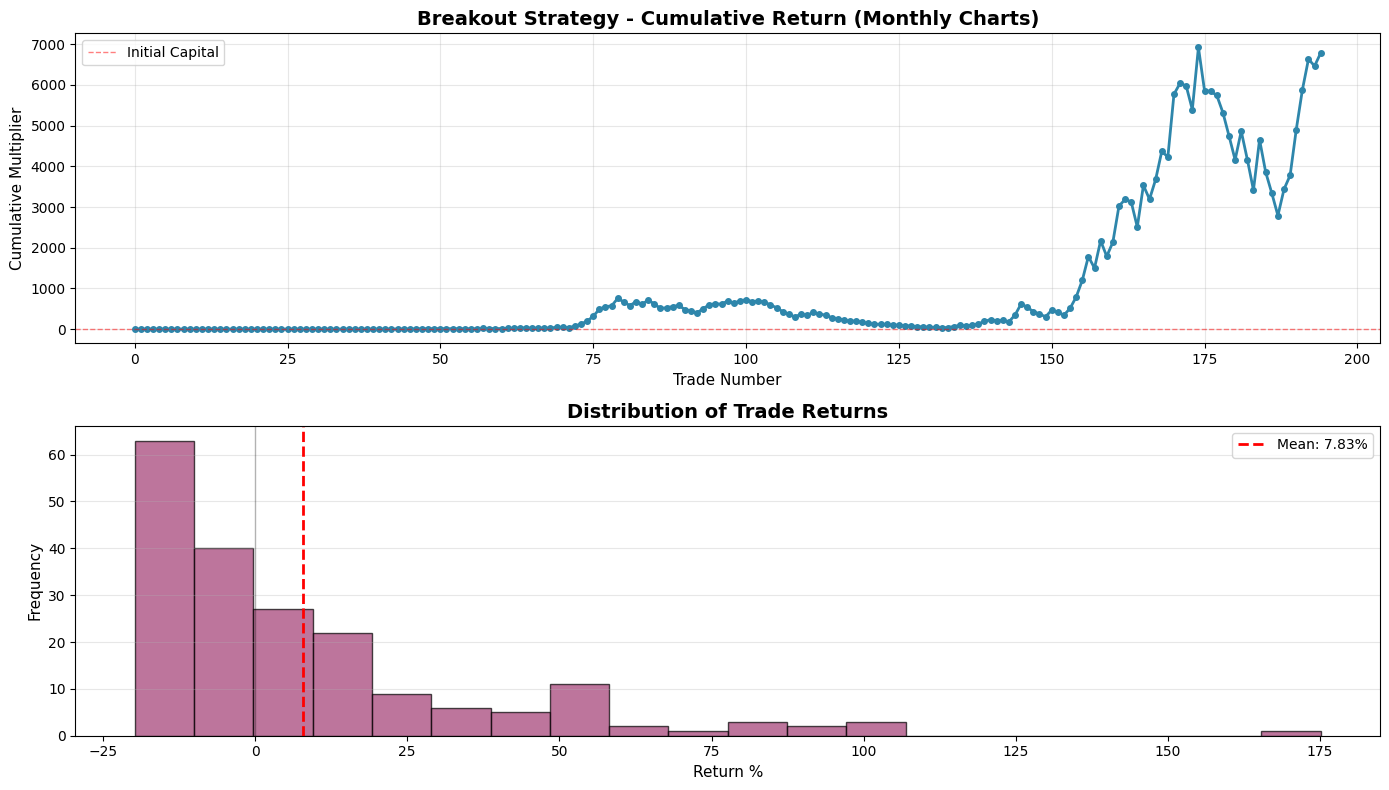

Equity curve and return distribution plotted.


In [11]:
# ============================================================================
# STEP 6: VISUALIZE RESULTS
# ============================================================================

if not results.empty:
    # Sort by entry date and calculate cumulative equity
    results_sorted = results.sort_values('entry_date').reset_index(drop=True)
    results_sorted['cumulative_return'] = (1 + results_sorted['net_return']).cumprod()
    
    # Plot equity curve
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))
    
    # Equity curve
    ax1.plot(range(len(results_sorted)), results_sorted['cumulative_return'], 
             marker='o', linestyle='-', linewidth=2, markersize=4, color='#2E86AB')
    ax1.axhline(y=1.0, color='red', linestyle='--', alpha=0.5, linewidth=1, label='Initial Capital')
    ax1.set_title('Breakout Strategy - Cumulative Return (Monthly Charts)', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Trade Number', fontsize=11)
    ax1.set_ylabel('Cumulative Multiplier', fontsize=11)
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Return distribution
    returns_pct = results['net_return'] * 100
    ax2.hist(returns_pct, bins=20, color='#A23B72', alpha=0.7, edgecolor='black')
    ax2.axvline(returns_pct.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {returns_pct.mean():.2f}%')
    ax2.axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.3)
    ax2.set_title('Distribution of Trade Returns', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Return %', fontsize=11)
    ax2.set_ylabel('Frequency', fontsize=11)
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    print('Equity curve and return distribution plotted.')

In [12]:
# ============================================================================
# STEP 7: EXPORT RESULTS
# ============================================================================

if not results.empty:
    # Save detailed trade log
    output_file = 'nse_monthly_breakout_trades.csv'
    results_export = results.copy()
    results_export['entry_date'] = results_export['entry_date'].dt.date
    results_export['exit_date'] = results_export['exit_date'].dt.date
    results_export['gross_return'] = results_export['gross_return'] * 100
    results_export['net_return'] = results_export['net_return'] * 100
    results_export = results_export.round(2)
    results_export.to_csv(output_file, index=False)
    print(f'✅ Trade log exported: {output_file}')
    print(f'   Total rows: {len(results_export)}')

✅ Trade log exported: nse_monthly_breakout_trades.csv
   Total rows: 195
